In [100]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import itertools
import matplotlib
from time import time
# from pandas.tools.plotting import table
import time
import os

from collections import Counter 
from math import sqrt, log

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, adjusted_rand_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from tqdm import tqdm
from copy import copy
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.preprocessing import normalize

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA, NMF, IncrementalPCA, FastICA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE

matplotlib.rcParams.update({'font.size': 16})

# plt.style.use("ggplot")
plt.style.use('default')


In [2]:
category = {}
category_sub = {}
description = {}

for nm in ["alphabay", "poseidon", "silkroad"]:
    description[nm], category[nm], category_sub[nm] = pickle.load(open("data/meta/{}_dataset.p".format(nm), "rb"))    
    print(nm, ":", len(description[nm]), "samples, \n", len(set(category[nm])),"mains, ", len(set(category_sub[nm])), "subs")

alphabay : 15222 samples, 
 12 mains,  48 subs
poseidon : 3688 samples, 
 10 mains,  36 subs
silkroad : 2137 samples, 
 1 mains,  22 subs


In [3]:
#
# reduce dimension
# Input: input, output_dimension 
# Out:   X, reduction_object
#


def red_dim(inp, dim_out, domain_bypass=False, norm=False):
    master_ = 70
    for name in os.listdir("data/meta/dim_reduce"):
        
        if domain_bypass:
            dom = domain_bypass
        else:
            dom = domain
                    
        if "svd_{}_".format(dom) in name:            
            prev_vectorizer, svd = pickle.load(open("data/meta/dim_reduce/{}".format(name), "rb"))    

            if str(vectorizer.get_params) == str(prev_vectorizer):
                print("Pre-Trained SVD found: {}".format(name))
                pca = svd
                X = pca.transform(inp)
                X = X[:,range(dim_out)]
                if norm:
                    X = normalize(X, axis=0)
                return X, pca

    pca = TruncatedSVD(n_components=master_, random_state=1)
    pca.fit(inp)
    
    fn_ = "data/meta/dim_reduce/svd_{}_{}_{}.bow".format(domain, inp.shape[1], int(time.time()))
    
    pickle.dump((vectorizer.get_params, pca), open(fn_,"wb"))
    print("Saving SVD: {}".format(fn_))
    
    X = pca.transform(inp)
    X = X[:,range(dim_out)]
    if norm:
        X = normalize(X, axis=0)
    return X, pca

In [4]:
# print(input_data.shape)
# # input_, pca = red_dim(input_data, 10 , domain_bypass='poseidon')
# input_, pca = lda(input_data, 3) #, domain_bypass='poseidon')
# print(input_.shape)
# print(input_[0])

In [5]:
#
# reduce dimension
# Input: input, output_dimension 
# Out:   X, reduction_object
#

def lda(inp, out_dim=False, mid_dim=3000, domain_bypass=False, norm=True):
    if domain_bypass:
        dom = domain_bypass
    else:
        dom = domain
                
    mid_,_ = red_dim(inp, mid_dim, domain_bypass=dom)

    # CHECK FOR PRE-TRAINED LDAs
    for name in os.listdir("data/meta/dim_reduce"):
        if "lda_{}_{}_".format(dom, mid_dim) in name:
            prev_vectorizer, lda = pickle.load(open("data/meta/dim_reduce/{}".format(name), "rb"))    
            if str(vectorizer.get_params) == str(prev_vectorizer):
                print("Pre-Trained LDA found: {}".format(name))
                pca = lda
                X = pca.transform(mid_)
                if out_dim:
                    X = X[:,range(out_dim)]
                if norm:
                    X = normalize(X, axis=0)
                return X, lda

    # TRAIN NEW LDA    
    pca = LinearDiscriminantAnalysis()

    X = pca.fit_transform(mid_, problem_numeric[:inp.shape[1]])
    od = X.shape[1]

    fn_ = "data/meta/dim_reduce/lda_{}_{}_{}.bow".format(domain,
                                                            mid_dim,
                                                            int(time.time()))
    pickle.dump((vectorizer.get_params, pca), open(fn_,"wb"))
    print("Saving LDA: {}".format(fn_))
    if out_dim:
        X = X[:,range(out_dim)]
    if norm:
        X = normalize(X, axis=0)
    return X, pca

In [6]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [7]:
#
# clf = list of estimators
#

def create_clf(inp_, domain_bypass=False, pre_trained=True):

    # construct the estimators
    clf = VotingClassifier([
                            ('Support Vector Classifier (RBF)',SVC()),
                            ('Naive Bayes Bernoulli',sklearn.naive_bayes.BernoulliNB()),
                            ('Ridge Classifier',sklearn.linear_model.RidgeClassifier()),
                            ('K-Nearest Neighbors',sklearn.neighbors.KNeighborsClassifier()),
                            ('Random Forest Classifier', RandomForestClassifier()),
        
                            ('Support Vector Classifier (Linear)', SVC(C=0.01, 
                                                             decision_function_shape='ovo', 
                                                             gamma=1, 
                                                             kernel='linear')),
        
                            ('Stochastic Gradient Descent', SGDClassifier(alpha=0.001,
                                                                        epsilon=0.01,
                                                                        l1_ratio=0.1,
                                                                        loss='hinge',
                                                                        penalty='l1')),
        
                            ('Multi Layer Perceptron (SGD)', MLPClassifier(alpha=0.0001,
                                                      solver='sgd')),
                            
                            ('Multi Layer Perceptron (Adam)', MLPClassifier(alpha=0.0001,
                                                      solver='adam')),
        
                            ('Multi Layer Perceptron (Adam)',  MLPClassifier(solver='adam',
                                                                            hidden_layer_sizes=(200,100)
                                                                            ))
                           ])

    #
    # Check if already trained
    #
    
    if domain_bypass:
        dom = domain_bypass
    else:
        dom = domain
    
    if pre_trained:
        for name in os.listdir("data/meta/clf"):
            if "{}_{}_".format(dom, inp_.shape[1]) in name:
                prev_vector, tmp_clf = pickle.load(open("data/meta/clf/{}".format(name), "rb"))
                if str(vectorizer.get_params) == str(prev_vector):
                    if str(tmp_clf.get_params) == str(clf.get_params):
                        print("Pre-Trained CLF found:" + name)
                        return tmp_clf
    
    
#     if pre_trained:
#         for name in os.listdir("data/meta/clfs"):
#             if str(inp_.shape[1]) in name:
#                 dom, data_shape, prev_vector, tmp_clf = pickle.load(open("data/meta/clfs/{}".format(name), "rb"))

#                 if domain == dom or domain_bypass == dom:
#                     print(":::{} & {}".format(data_shape, inp_.shape))
#                     if str(data_shape[1]) == str(inp_.shape[1]):
#                         if str(vectorizer.get_params) == str(prev_vector):
#                             if str(tmp_clf.get_params) == str(clf.get_params):
#                                 print("Pre-Trained CLF found:" + name)
#                                 return tmp_clf
    

    #
    # Train new - if none exist
    #
    X_train, X_test, y_train, y_test = train_test_split(inp_, problem_numeric, test_size=0.25, random_state=1)
    clf.fit(X_train, y_train)

    pickle.dump((vectorizer.get_params, clf), open("data/meta/clf/{}_{}_{}.clf".format(domain, 
                                                                                        inp_.shape[1],
                                                                                        int(time.time())), 
                                                   "wb"))
    
    print("Saving CLF as {}_{}_{}.clf".format(domain, inp_.shape[1], int(time.time())))

    return(clf)

#
# ---
#

# input_ = input_data
# clf = create_clf(input_)
# clfD = (clf, input_, "none", "{} - Default".format(input_.shape[1]))

# clfs = [clfD]
# #clfs = []
# for x in tqdm([1000, 300, 5, 3]):
#     input_, pca = red_dim(input_data, x)
#     clf = create_clf(input_)
#     clfs.append((clf, input_, pca, "{}dim".format(x)))

In [8]:
#
# Plot result of multiple classifiers (clfs)
#


def plot_clfs(clf_list, best_line=False):    
    %matplotlib inline
    best_score = 0
    
    fig = plt.figure(figsize=(25,7))
    matplotlib.rcParams.update({'font.size': 27})

    for ind, clf_tup in tqdm(enumerate(clf_list)):
        clf_, input_, pca_, names = clf_tup
        _, X_test, _, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)
        
        clf_count = np.arange(len(clf_.estimators))
        clf_scores = [est.score(X_test, y_test) for est in clf_.estimators_]
        
        clf_names = [n[0] for n in clf_.estimators]
        plt.bar(clf_count+((.8/len(clf_list)))*ind-.35, clf_scores, width=.8/(len(clf_list)), label=names)

        plt.xticks(clf_count, clf_names)
    
        if max(clf_scores)>best_score:
            best_score = max(clf_scores)
        
    if best_line:
        plt.axhline(y=best_score)
    
    fig.autofmt_xdate()

#     plt.legend(ncol=3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("{}\n{}%".format(domain.capitalize(), round(best_score*100, 1)))
    plt.ylim([0,1])
    plt.xlabel("Estimator")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()

# plot_clfs(clfs)

In [9]:
#
# F1 score measure
#

def eval_clf(clf_inp):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    classifier, input_, pca_, names = clf_inp

    X_train, X_test, y_train, y_test = train_test_split(input_, problem_numeric, test_size=0.25, random_state=1)

    fig = plt.figure(figsize=(12,8))
    clf_count = len(classifier.estimators)
    
#     tmo = sorted(classifier.estimators_, key=lambda x: x.score, reverse=True)

    for i, clfs_ in tqdm(enumerate(classifier.estimators_)):
        y_pred = clfs_.predict(X_test)
        scores = []
        for avg in ['weighted', 'micro', 'macro']:
            scores.append(f1_score(y_test, y_pred, labels=list(set(problem_numeric)), average=avg))            
        plt.bar(np.arange(3)+((.8/len(classifier.estimators_))*i)-.1, scores, width=(.8/len(classifier.estimators_)), label=classifier.estimators[i][0])
        plt.title(names.capitalize())

    plt.xticks(range(3), ['F1 Weighted', 'F1 Micro', 'F1 Macro'])
#     plt.legend(loc='upper left',ncol=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.autofmt_xdate()
    plt.ylim([0,1])
    plt.xlabel("Evaluation method")
    plt.ylabel("Accuracy")
    fig.show()
    plt.show()
    
    
# for clf_ in clfs:
#     eval_clf(clf_)

In [31]:
#
# Plot confussion matrix
#


def plot_confusion_matrix(clf, normalize=False, estimator=None, prob=None):    
    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})

    if prob:
        target_val = prob
    else:
        target_val = problem_numeric
    
    classes = sorted(list(set(problem)))
    classifier, input_, pca_, names = clf
    if estimator:
        names = classifier.estimators[estimator][0] + " : " + names
        classifier = classifier.estimators_[estimator]
        
    X_train, X_test, y_train, y_test = train_test_split(input_, target_val, test_size=0.25, random_state=1)
    
    y_pred = classifier.predict(X_test)
    print("Accuracy:",classifier.score(X_test, y_test))
 
    cm = confusion_matrix(y_test, y_pred)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix \n {}'.format(names)
    else:
        title = 'Confusion matrix \n {}'.format(names)
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(10, 10) #(22, 14)

    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())
    plt.title(title.capitalize())
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() * 0.85
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] < 0.01:
            continue
        if normalize:
            thresh = .64
            val = str(round(cm[i, j]*100,2)).split(".")[0]+'%'
        else:
            val = cm[i, j]
            
        if cm[i, j] > thresh:
            cl="white"
        else:
            cl="black"
            
        plt.text(j, i, val, horizontalalignment="center", color=cl) #, alpha=cm[i,j]

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# plot_confusion_matrix(clfs[0])
# plot_confusion_matrix(clfs[0], normalize=True)

In [11]:
#
# Plot X (3D)  
# Input: X (global)
#

def plot_data_3d(text=False, specific_cat=False):
    %matplotlib inline
    
    matplotlib.rcParams.update({'font.size': 16})

    X3d,_ = red_dim(input_data, 3)
#     X3d,_ = lda(input_data)
    
    fig = plt.figure(1, figsize=(13, 10))
    ax = Axes3D(fig)
    y = problem
    for name, label in zip(list(set(problem)), list(set(y))):  
        if specific_cat!=False:
            if not name in specific_cat:
                continue
                
        ax.scatter(X3d[[label==t for t in y], 0], 
                  X3d[[label==t for t in y], 1],
                  X3d[[label==t for t in y], 2], 
                   label=name, 
                   s=25,
                   marker = 'o',
#                    c='B',
#                    marker = '+',
                   alpha=1)
   
        if text:
            ax.text3D(X3d[[label==t for t in y], 0].mean(),
                      X3d[[label==t for t in y], 1].mean(),
                      X3d[[label==t for t in y], 2].mean(), name)          

    plt.title(domain.capitalize()+"\n")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.legend(loc='upper left', ncol=2)
    ax.set_xlabel('\nPCA 0')
    ax.set_ylabel('\nPCA 1')
    ax.set_zlabel('\nPCA 2')
    
## Poseidon
#     plt.xlim([10, 20])
#     plt.ylim([-5, 5])
## Alphabay  
#     plt.xlim([-8, 4]) #9
#     plt.ylim([-7, 20])
#     ax.set_zlim([-21, 5])
    
    plt.show()
    return(X3d)

In [12]:
#
# Plot X (2D)  
# Input: X2d (global)
#


def plot_data_2d(text=False, specific_cat=False):
    %matplotlib inline
    
    matplotlib.rcParams.update({'font.size': 16})

    X2d,_ = red_dim(input_data, 2)
#     X2d,_ = lda(input_data)

    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        if specific_cat!=False:
            if not name in specific_cat:
                continue

        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    marker = '+',
                    label=name, 
#                     c='r',
                    s=25,
                    alpha=1,
                   )
        if text:
            plt.text(X2d[[name==t for t in y], 0].mean(),
                     X2d[[name==t for t in y], 1].mean(),
                     name)
    plt.title(domain.capitalize())
    plt.xlabel("PCA 0")
    plt.ylabel("PCA 1")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     plt.xlim([0, 125])
#     plt.ylim([-20, 80])
#     plt.xlim([-.025, .025])
#     plt.ylim([-.025, .1])
    
    plt.show()
    return X2d

# plot_data_2d()

# for x in set(category["alphabay"]):
#     print(x)
#     plot_data_2d(text=False, specific_cat=x)

In [13]:
#
# Scree plot
#

def scree(dim=1000, threshold=.9):
    
    if dim >= input_data.shape[1]:
        dim = int(input_data.shape[1]/2)
        
    xRed_, pca2 = red_dim(input_data, dim)


    plt.ylim(0)
#     plt.text(1,0.85,"Number of components\n"+str(input_data.shape[1]))
    var_rat = np.cumsum(pca2.explained_variance_ratio_)
    var = np.cumsum(pca2.explained_variance_)
    var = [float(i)/pca2.explained_variance_[0] for i in pca2.explained_variance_]

    %matplotlib inline
    matplotlib.rcParams.update({'font.size': 16})
    plt.ylabel("Variance")
    plt.xlabel("Components")
    plt.title("{}\n{} Features".format(domain.capitalize(), input_data.shape[1]))
    plt.plot(var_rat, label="Cumulative variance ratio")
    plt.plot(var, label="Normalized variance")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim([0,1])
    plt.show()
    
    for i, x in enumerate(var_rat):
        if x > threshold:
            return i
    return dim
        
# scree(100, .95)

In [14]:
#
# Make same domain etc.
#
if len(set(category["poseidon"])) != len(set(category["alphabay"])):
    description["poseidon"].append('Services sad sd')
    description["poseidon"].append('Jewels&Gold sad sd')
    category["poseidon"].append('Services')
    category["poseidon"].append('Jewels&Gold')

pprint(len(set(category["poseidon"])))
pprint(len(set(category["alphabay"])))

12
12


In [181]:
#
# TFIDF w/o using countvectorizer (Equivalent to CountVectorizer + TfidfTransformer)
#
def tfidf(inp):
    global vectorizer
    
#     vectorizer = HashingVectorizer(n_features=50000)
#     vectorizer = HashingVectorizer(n_features=250000, non_negative=True)
#     inp = vectorizer.fit_transform(inp)
#     vectorizer = TfidfTransformer(sublinear_tf=False, use_idf=True)
    
#                                   token_pattern=u'\\w[A-Za-z]{3,10}\\b')
    
    vectorizer = CountVectorizer( 
#                                 analyzer='char',
#                                 strip_accents='ascii',
                                
#                                 min_df=5, 
#                                 max_df = 0.7,
#                                 token_pattern=u'\\w[A-Za-z]{3,10}\\b',
#                                 token_pattern=u'\\w[A-Za-z]\\b',
#                                 ngram_range=(1,2)
                                )
    
#     vectorizer = TfidfVectorizer(use_idf=True,
#                                 analyzer='char',
#                               stop_words='english',
#                                 ngram_range=(1,3),
#                                 min_df = 0.01,
#                                 max_df= 0.5,
# #                                     vocabulary=voce,
#                                 sublinear_tf=True)
    
    ans = vectorizer.fit_transform(inp)
    return ans

# input_data = tfidf(description[domain])

In [182]:
domain = "alphabay"
problem = category[domain]
input_data = tfidf(description[domain])
problem_numeric = [sorted(list(set(category[domain]))).index(x) for x in problem]

print("Samples:", len(problem))
print("Features:", input_data.shape[1])

Samples: 15222
Features: 81187


Pre-Trained SVD found: svd_alphabay_81187_1497462268.bow


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.747687779072
Accuracy: 0.778507619548
[[   1    1    0   12   34    4    1    0    0    2    0    0]
 [   1   77    1   12   13   10    0    0    0    0    0    0]
 [   0    0  151    8  106   56    0    0    0    1    3    0]
 [   0    3    1 1708   15    2    0    0    0    1    0    0]
 [   1    9   18   28  708   68    0    0    0    5    0    0]
 [   2    1   23    3   91  262    0    0    0    1    0    0]
 [   0    7    0    9    1    1   38    0    0    0    0    0]
 [   1    1    7    9   41    3    0    0    0    0    0    0]
 [   0    0    0    0    8    1    0    0    1    0    0    0]
 [   0    0    2    4  133    8    0    0    0   11    0    1]
 [   0    1    5    0   14    3    0    0    0    1    3    0]
 [   0    0    3   31    6    5    0    0    0    0    0    3]]
0.737545956231
Accuracy: 0.762480294272
[[   0    0    0   16   30    5    0    0    0    4    0    0]
 [   0   65    1   19   12   13    3    0    0    1    0    0]
 [   1    3  148   10  115   42    0 

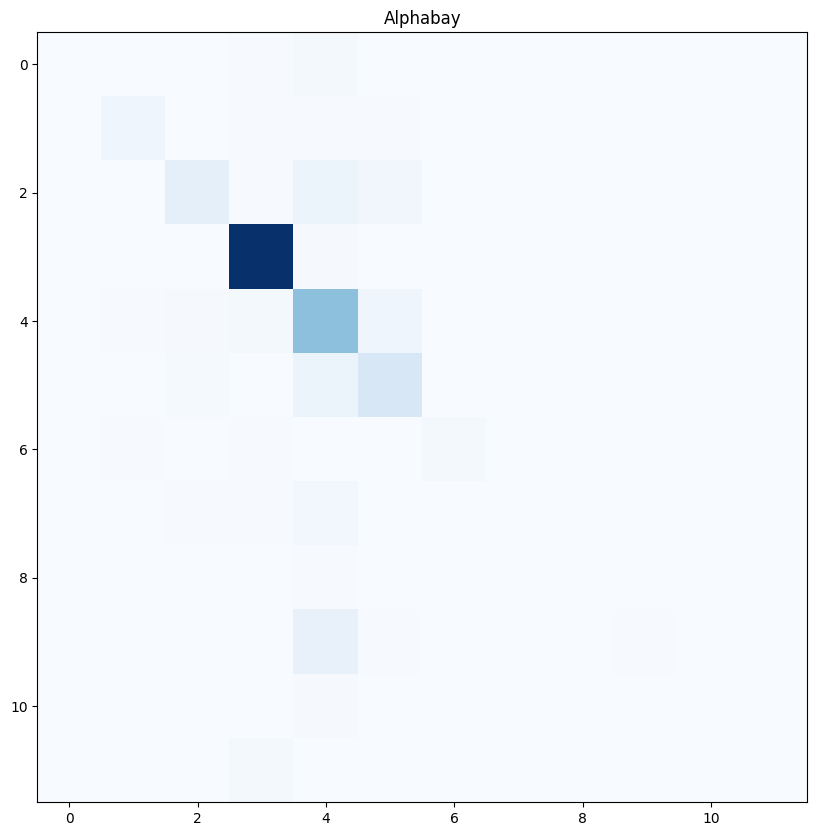

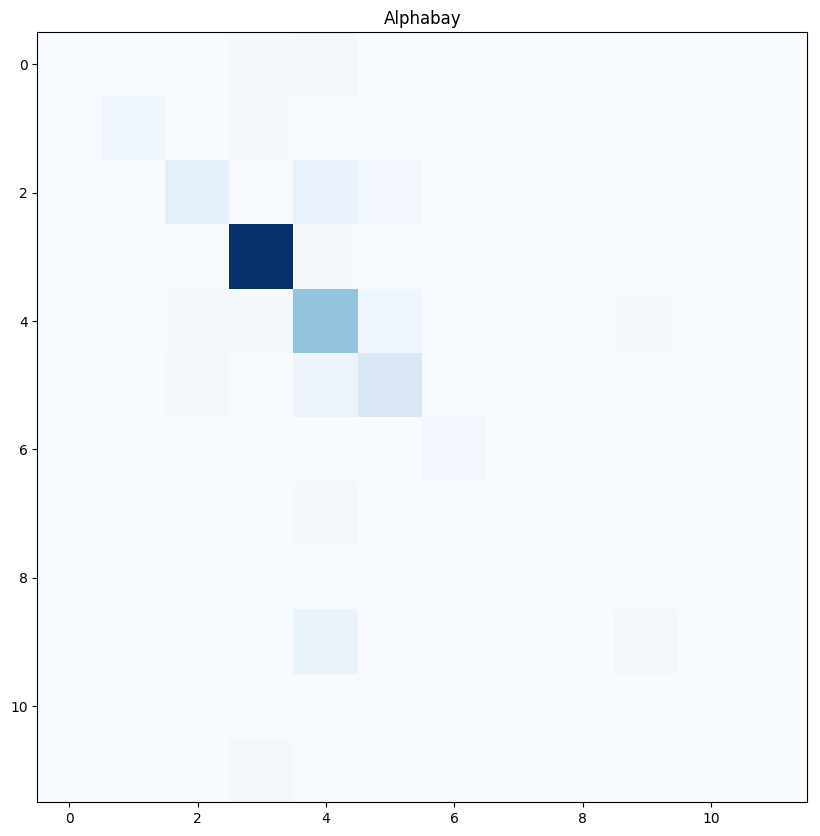

In [184]:
inp_ = input_data[::1]
tar_ = problem_numeric[::1]

inp_ , pca = red_dim(inp_, 100)


X_train, X_test, y_train, y_test = train_test_split(inp_, tar_, test_size=0.25, random_state=1)

# cl = SGDClassifier(random_state=1)
# cl = SVC()
cl = SVC(C=0.01, decision_function_shape='ovo', gamma=1, kernel='linear')

cl.fit(X_train, y_train)

y_pred = cl.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

print("Accuracy:", cl.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

#
# - - - 
#

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(10, 10)

cmap = plt.cm.Blues
plt.title(domain.capitalize())
plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())


# eval_clf(tmp)
# plot_confusion_matrix(cl, normalize=True)

sam_we = [1] * X_train.shape[0]
ws = Counter(y_train)
for i, x in enumerate(y_train):
    sam_we[i] = (1./(sqrt(ws.get(x))*.75))
    
cl.fit(X_train, y_train, sample_weight = sam_we)

y_pred = cl.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))


print("Accuracy:", cl.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

#
# - - - 
#

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(10, 10)

cmap = plt.cm.Blues
plt.title(domain.capitalize())
plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0., vmax=cm.max())


# eval_clf(tmp)
# plot_confusion_matrix(cl, normalize=True)

Pre-Trained SVD found: svd_alphabay_77_1497956981.bow


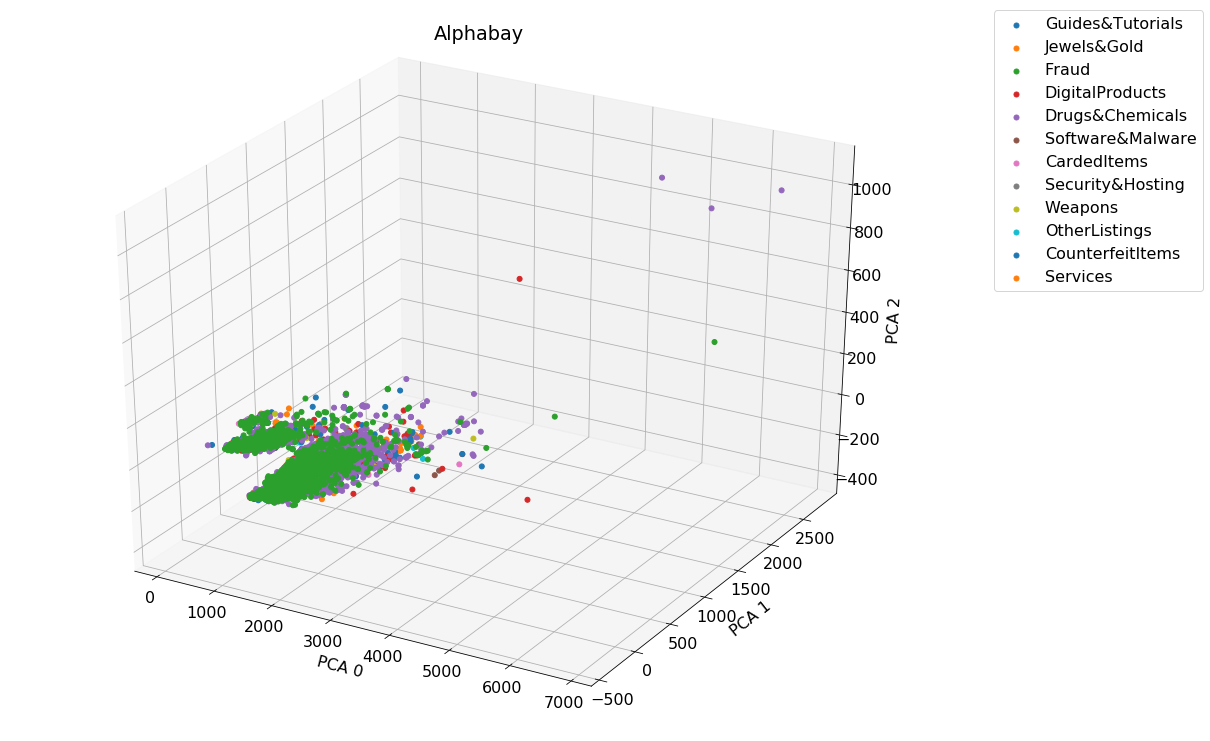

Pre-Trained SVD found: svd_alphabay_77_1497956981.bow


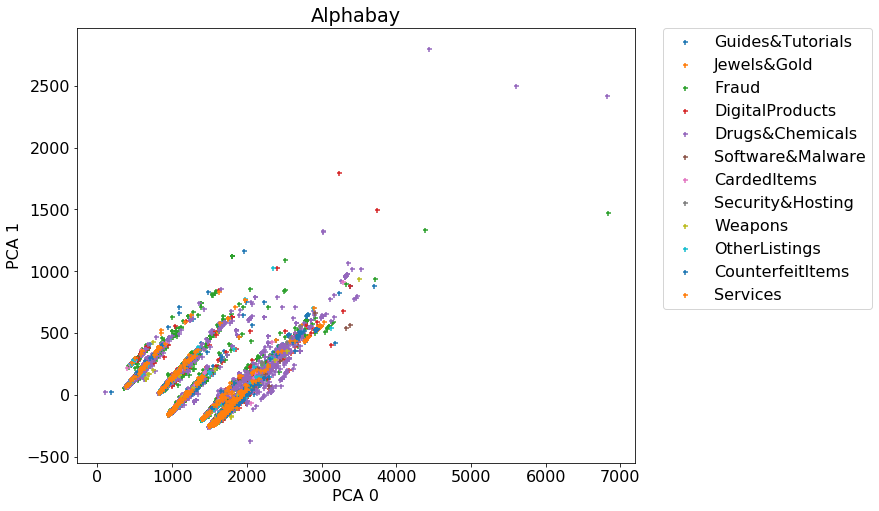

array([[  617.42709481,   363.34002403],
       [  553.87222044,   162.39956071],
       [ 1904.37377658,    12.71498438],
       ..., 
       [ 2029.71637427,    75.30845325],
       [ 1790.95383094,   -61.89541073],
       [ 1904.10297914,    13.52501331]])

In [17]:
##
## Visualize data
##

plot_data_3d()
plot_data_2d()

Pre-Trained SVD found: svd_alphabay_77_1497956981.bow


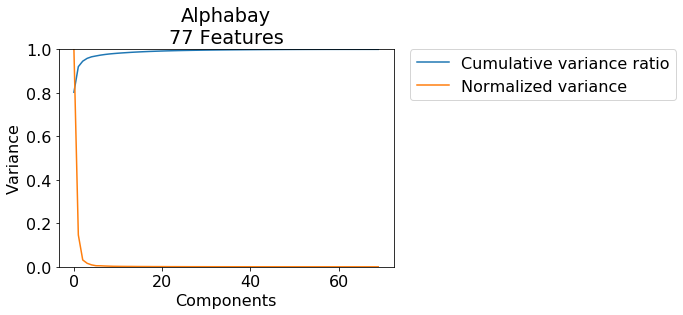

99% - 17 Components


In [18]:
##
## Check when exp. var > treshold (nm of useful features) 
##

dims = scree(70, .99)
print("99% -", dims, "Components")

In [24]:
##
## Train models 
##

clf = create_clf(input_data)
clfD = (clf, input_data, "none", "{} - Default".format(input_data.shape[1]))
clfs = [clfD]

# clfs = []
for x in tqdm([70]): #, int(dims), int(dims/2), int(dims/4), int(dims/8), 5
    input_, pca = red_dim(input_data, x , domain_bypass='poseidon')
#     input_, pca = lda(input_data) #, domain_bypass='poseidon')
    clf = create_clf(input_) #, domain_bypass='poseidon')
    clfs.append((clf, input_, pca, "{}dim".format(x)))

# input_, pca = lda(input_data)#, domain_bypass='poseidon')
# input_ = input_data
# clf = create_clf(input_)#, domain_bypass='poseidon')
# clfs.append((clf, input_, pca, "{} dim".format("3000\nIntermediate")))


  0%|          | 0/1 [00:00<?, ?it/s]

Saving SVD: data/meta/dim_reduce/svd_alphabay_77_1497958113.bow


100%|██████████| 1/1 [14:28<00:00, 868.23s/it]

Saving CLF as alphabay_70_1497958976.clf


2it [00:25, 14.54s/it]
/home/hades/.local/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


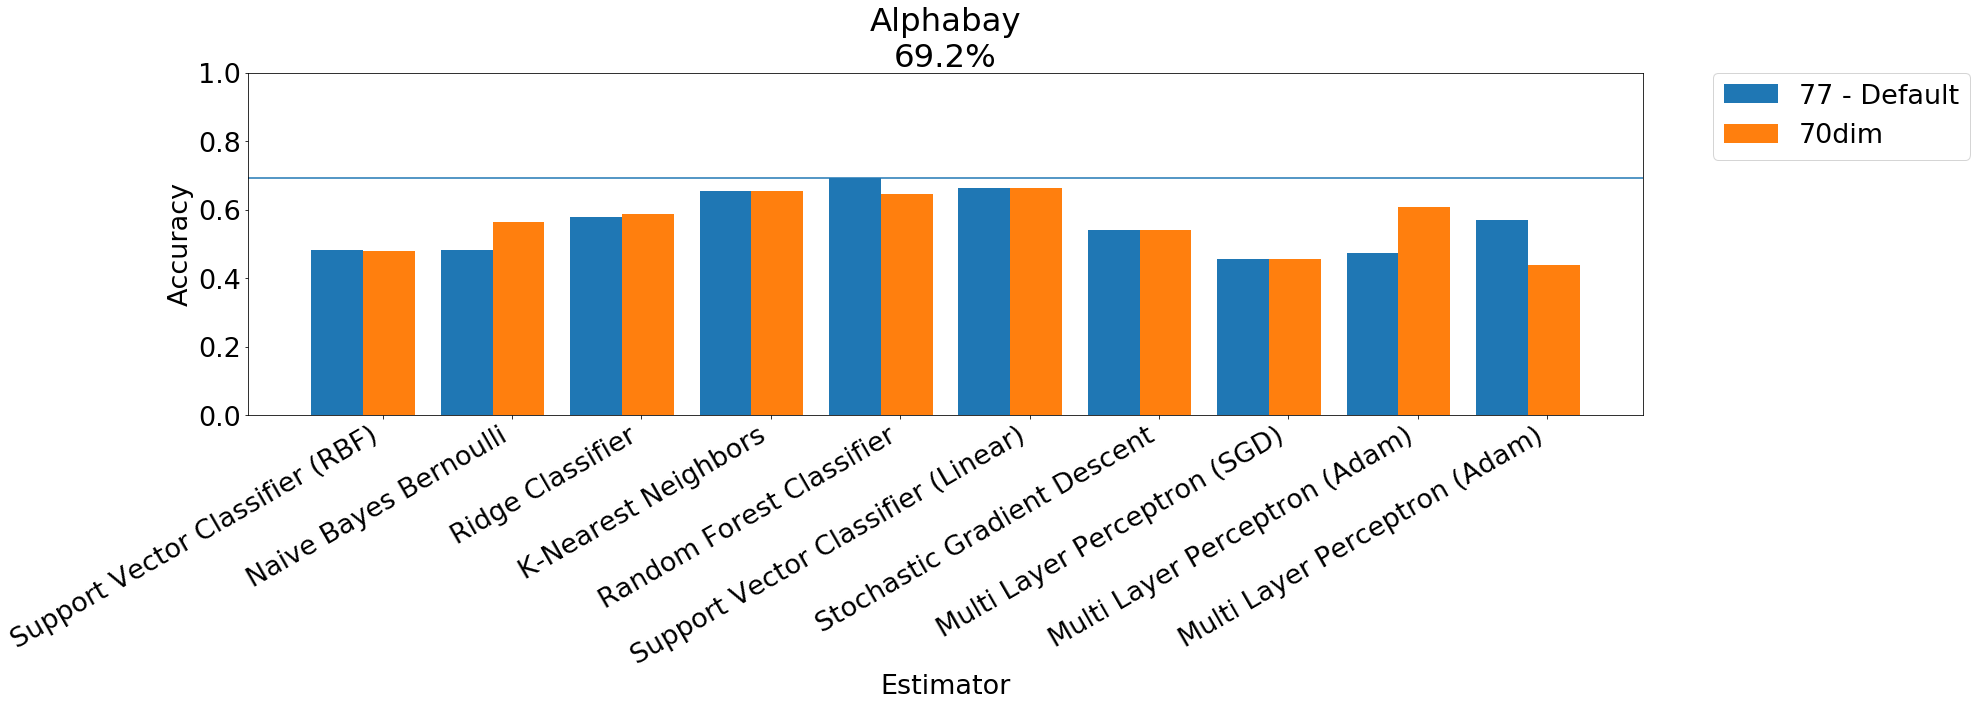

In [25]:
##
## Display result
##

plot_clfs(clfs, best_line=True)

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
10it [00:19,  3.48s/it]
/home/hades/.local/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


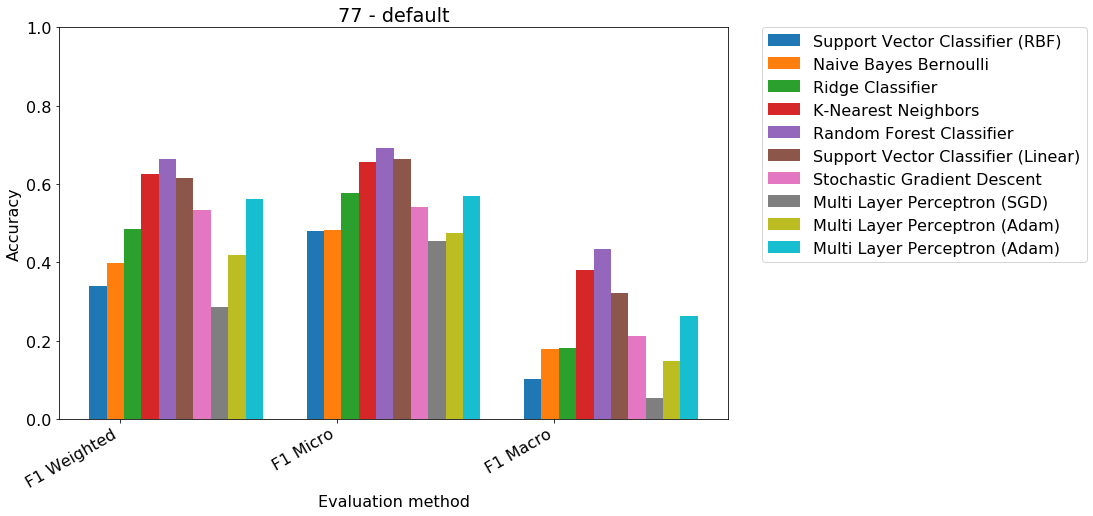

Accuracy: 0.593273778245


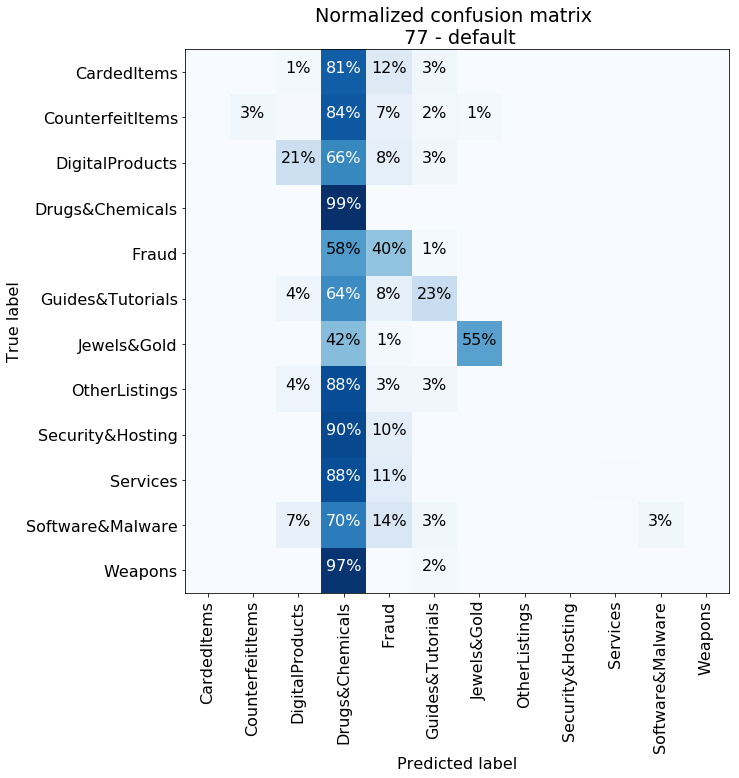

10it [00:08,  1.13it/s]


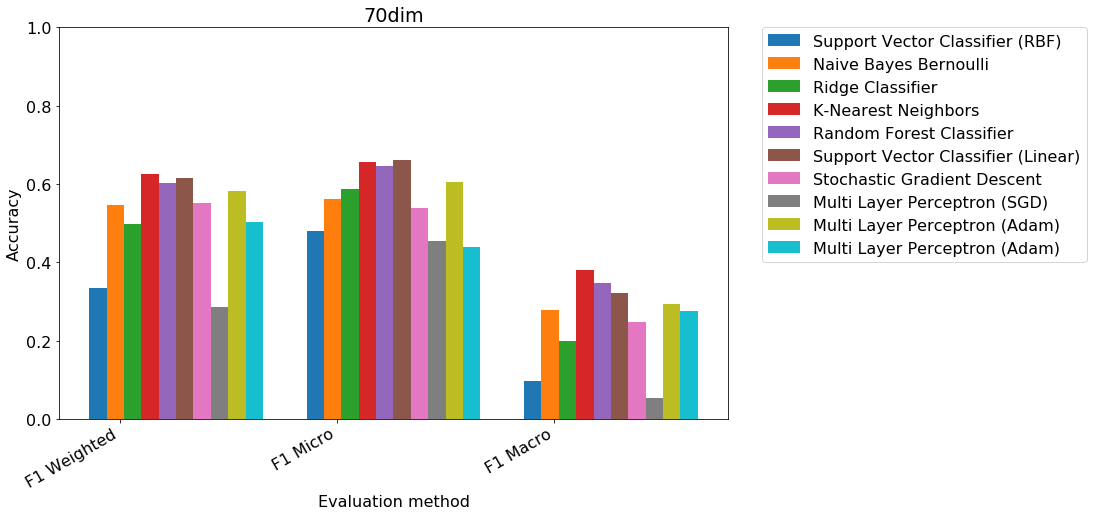

Accuracy: 0.633473462953


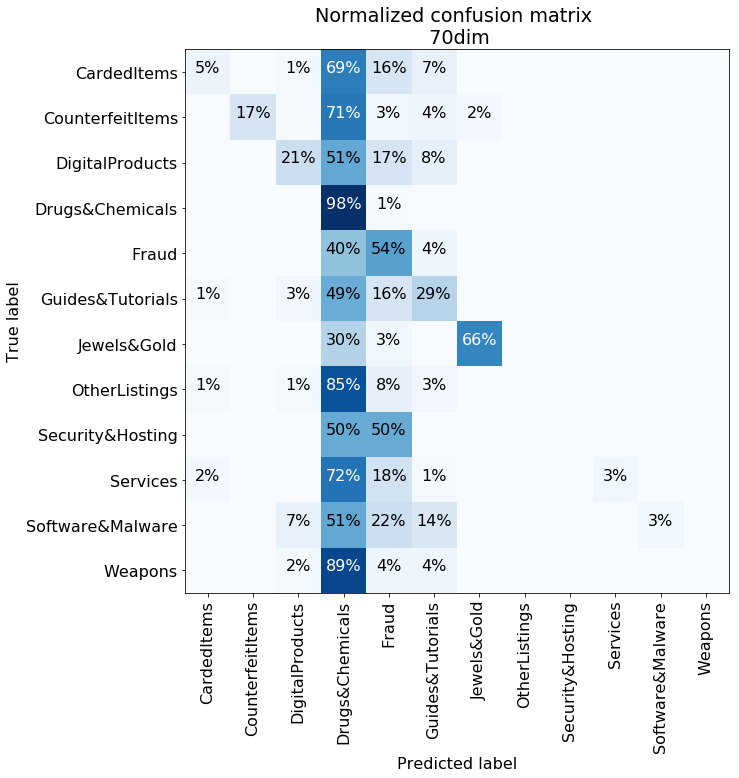

In [26]:
##
## Result F1 & Confusion matrix
##

for clf_ in clfs:
    eval_clf(clf_)
    plot_confusion_matrix(clf_, normalize=True)

Accuracy: 0.633473462953


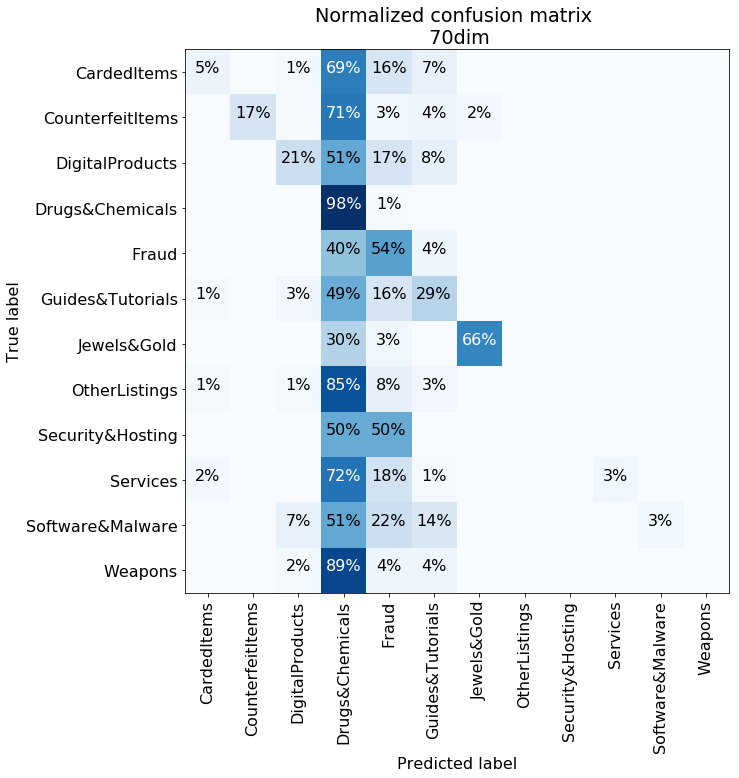

Accuracy: 0.56253284288


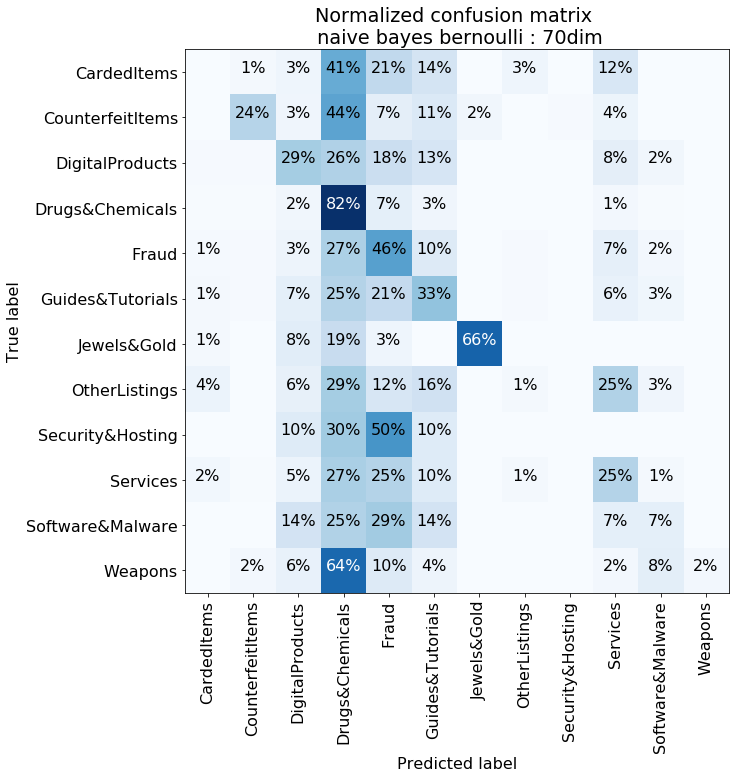

Accuracy: 0.587756174461


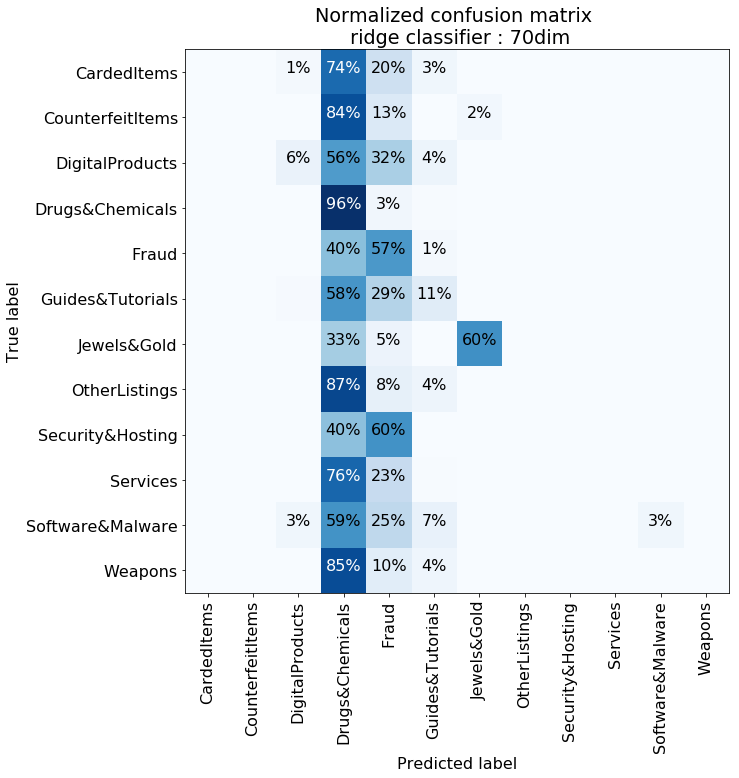

Accuracy: 0.655018392013


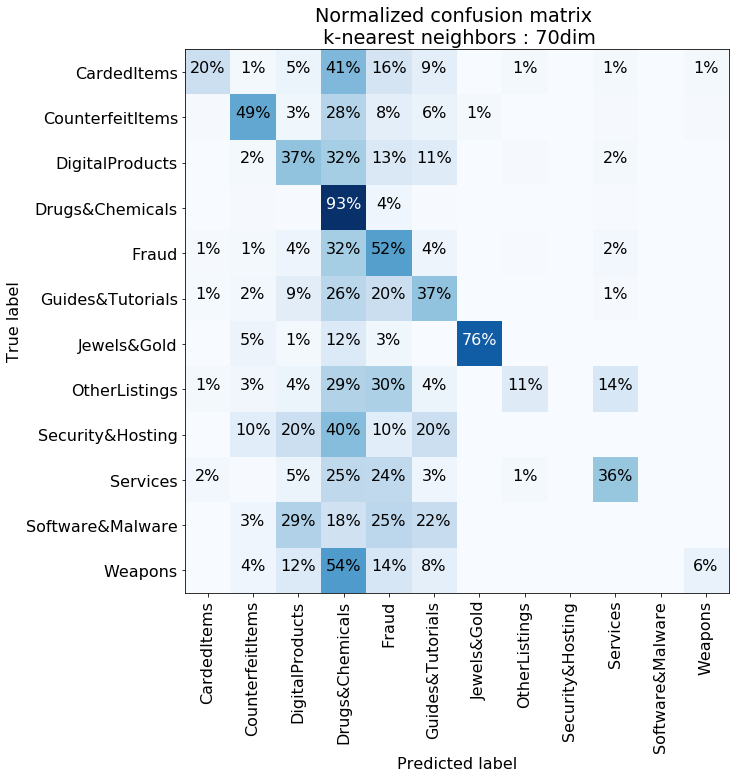

Accuracy: 0.644771413558


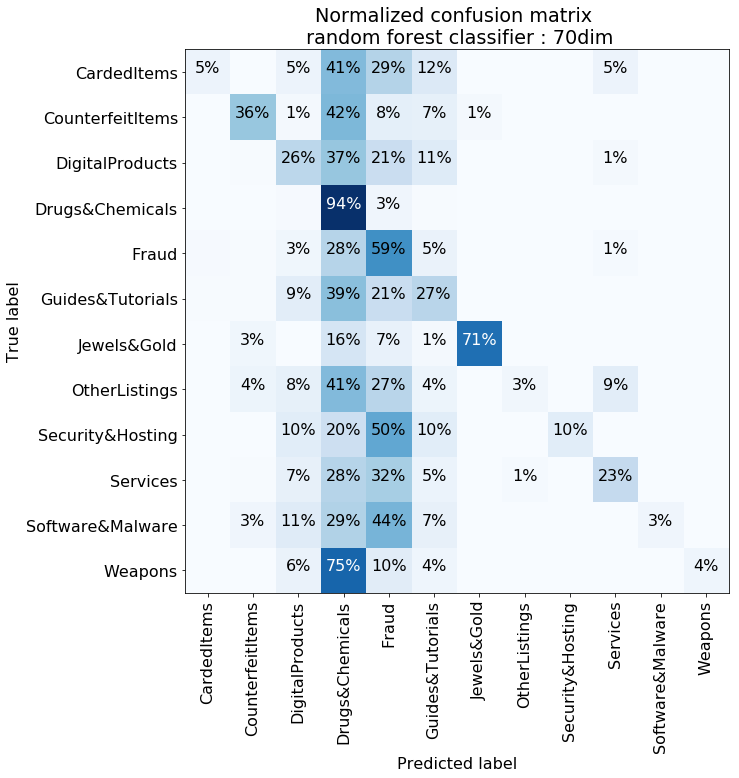

Accuracy: 0.66211245402


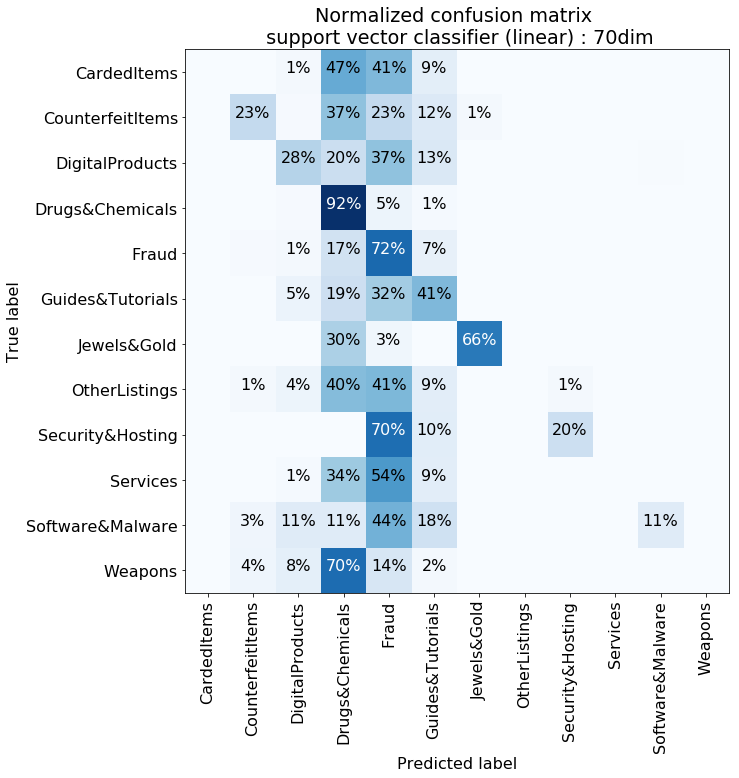

Accuracy: 0.539411455596


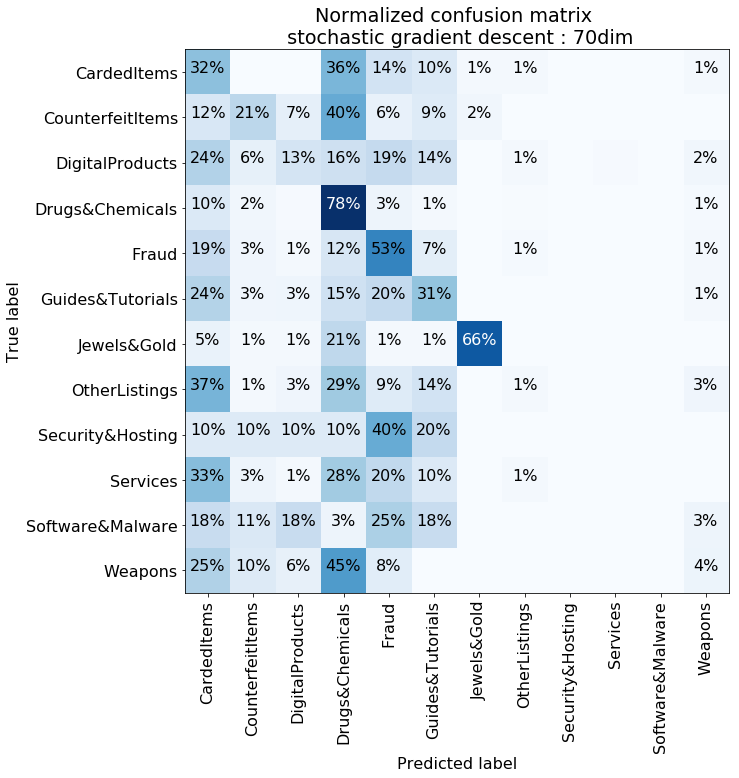

Accuracy: 0.45507094062


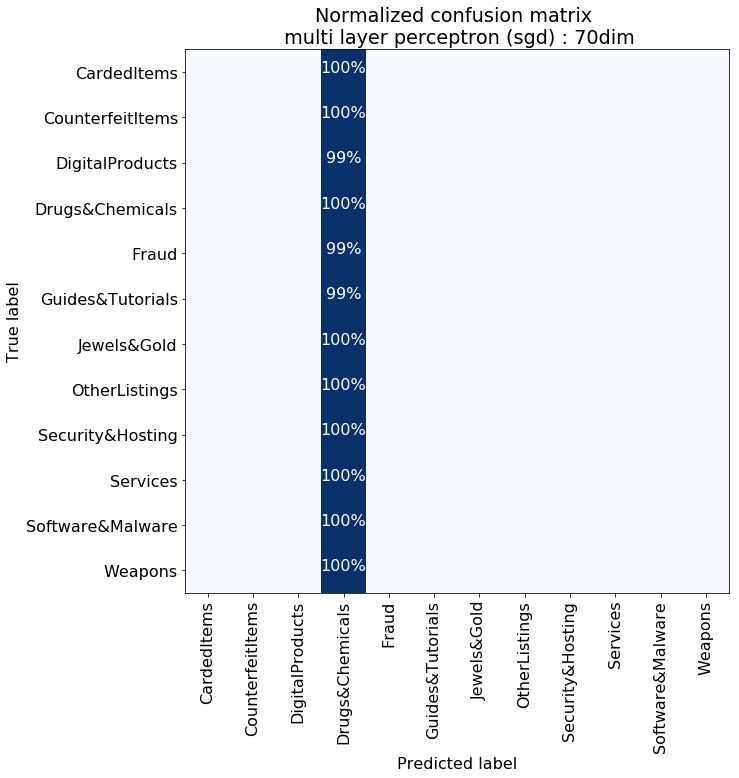

Accuracy: 0.606148187073


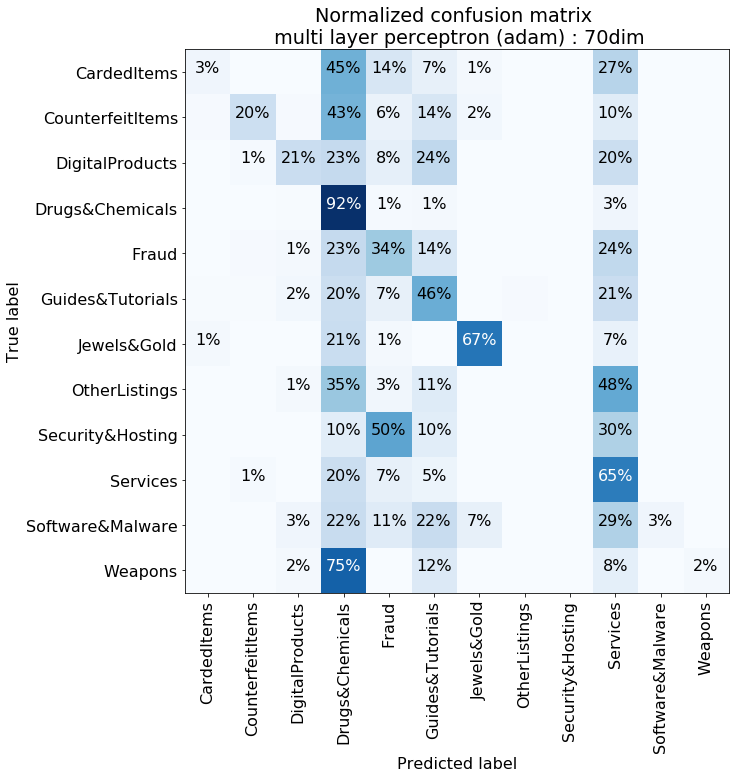

Accuracy: 0.439043615344


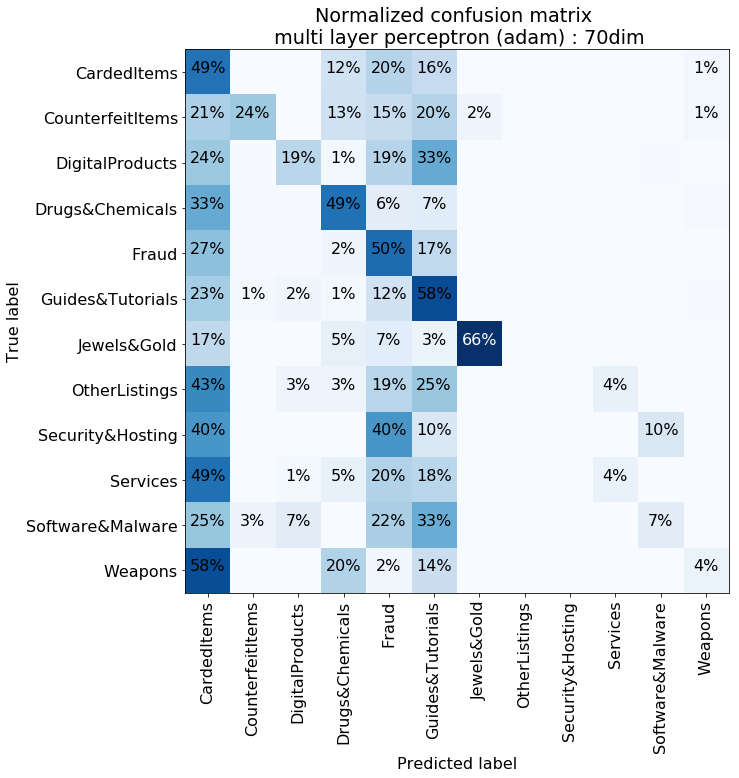

In [27]:
for x in range(10):
    plot_confusion_matrix(clfs[-1], normalize=True, estimator=x)
# plot_confusion_matrix(clfs[-1], normalize=False, estimator=-1)

# plot_confusion_matrix(clfs[0], normalize=True, estimator=-1)
# plot_confusion_matrix(clfs[0], normalize=False, estimator=-1)

In [23]:
from sklearn.model_selection import GridSearchCV

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
parameters = {'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'n_neighbors':[3, 5, 10]}

# svr = svm.SVC()
svr = sklearn.neighbors.KNeighborsClassifier()

clf = GridSearchCV(svr, parameters)

clf.fit(input_data, problem_numeric)
                            
sorted(clf.cv_results_.keys())

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.5/dist-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.5/dist-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.5/dist-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("can

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [24]:
clf.cv_results_

{'mean_fit_time': array([ 0.00370781,  0.00259558,  0.00350308,  0.00522049,  0.00271678,
         0.00361975,  0.0031724 ,  0.00266806,  0.00267347,  0.00267164,
         0.00277217,  0.00249775]),
 'mean_score_time': array([ 0.35362188,  0.32094415,  0.37377214,  0.30297462,  0.36465383,
         0.33384522,  0.30917939,  0.32529998,  0.31747675,  0.28538346,
         0.31076233,  0.31096435]),
 'mean_test_score': array([ 0.96476965,  0.96395664,  0.92086721,  0.96476965,  0.96395664,
         0.92086721,  0.96476965,  0.96395664,  0.92086721,  0.96476965,
         0.96395664,  0.92086721]),
 'mean_train_score': array([ 0.96897034,  0.96883506,  0.92506615,  0.96897034,  0.96883506,
         0.92506615,  0.96897034,  0.96883506,  0.92506615,  0.96897034,
         0.96883506,  0.92506615]),
 'param_algorithm': masked_array(data = ['auto' 'auto' 'auto' 'ball_tree' 'ball_tree' 'ball_tree' 'kd_tree'
  'kd_tree' 'kd_tree' 'brute' 'brute' 'brute'],
              mask = [False False False F